In [ ]:
pip install pmdarima

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import minmax_scale
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math


In [ ]:
# load stock data into pandas DataFrame
df = pd.read_csv('vix_data.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df = df.fillna(method='bfill')
df = df.drop(['(R1) Open', '(R1) High', '(R1) Low'], axis=1)
df = df[::-1]
df.index = df.index[::-1]
df = df[:-1]
df

,Date,NIFTY Index - Volume (L1),(R1) Close,NIFTY 30d volatility,3mo LIBOR,US T-bond 10y yield,CBOE VIX,MSCI EAFE Index,WTI Crude Oil Futures
0,2018-01-29,249220720,11130.40,7.00,1.77225,2.70,13.84,2.70,65.56
1,2018-01-30,234969504,11049.65,7.53,1.77340,2.73,14.79,2.73,64.50
2,2018-01-31,253462576,11027.70,7.46,1.77777,2.72,13.54,2.72,64.73
3,2018-02-01,315743488,11016.90,7.43,1.78698,2.78,13.47,2.78,65.80
4,2018-02-02,291432000,10760.60,10.62,1.78902,2.84,17.31,2.84,65.45
...,...,...,...,...,...,...,...,...,...
1233,2023-01-19,237833984,18107.85,12.39,4.81529,3.39,20.52,3.39,80.33
1234,2023-01-20,237225264,18027.65,12.44,4.81557,3.48,19.85,3.48,81.31
1235,2023-01-23,202460432,18118.55,12.39,4.81771,3.52,19.81,3.52,81.62
1236,2023-01-24,216910304,18118.30,12.34,4.82186,3.46,19.20,3.46,80.13


In [ ]:

# make input-output pairs

def LR_create_input_output_pairs(mydata, output_timesteps, length):
    X, y = [], []
    for i in range(len(mydata) - length - output_timesteps + 1):
        X.append(mydata[i:i+length, :])
        y.append(mydata[i+length+1:i+length+output_timesteps, 2])
    X = np.array(X)
    Y = np.array(y)
    print(X.shape, Y.shape)
    return X, Y


In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')


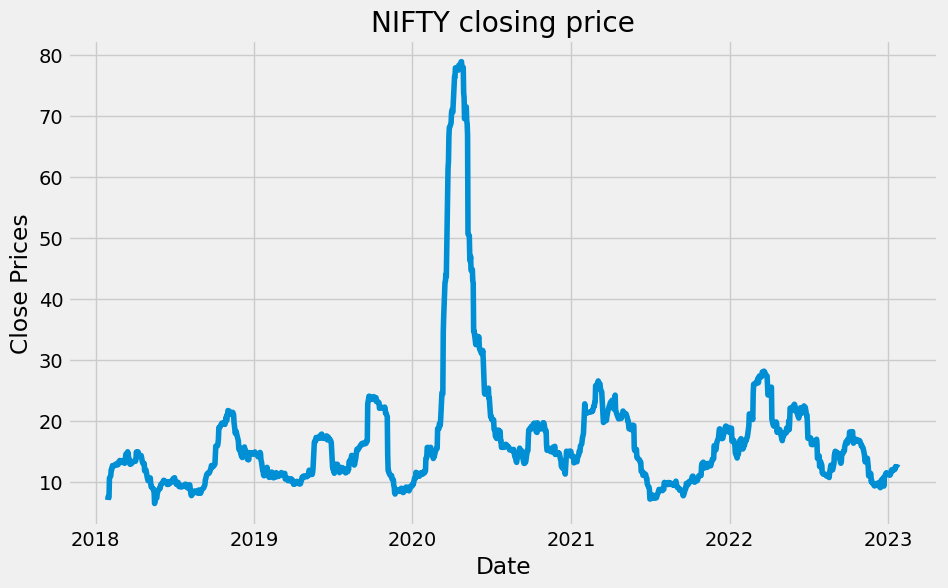

In [ ]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Date'],df['NIFTY 30d volatility'])
plt.title('NIFTY closing price')
plt.show()

<Axes: ylabel='Density'>

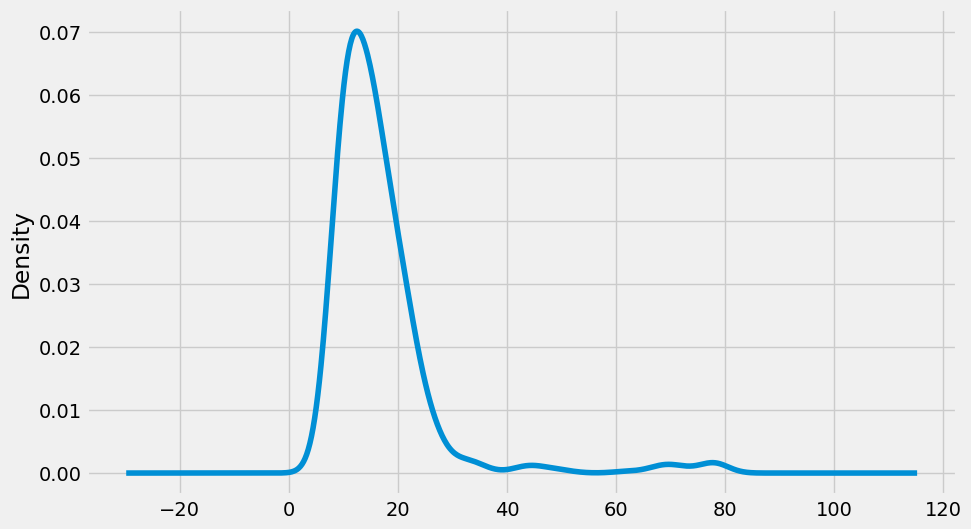

In [ ]:
#Distribution of the dataset
df_close = df['NIFTY 30d volatility']
df_close.plot(kind='kde')

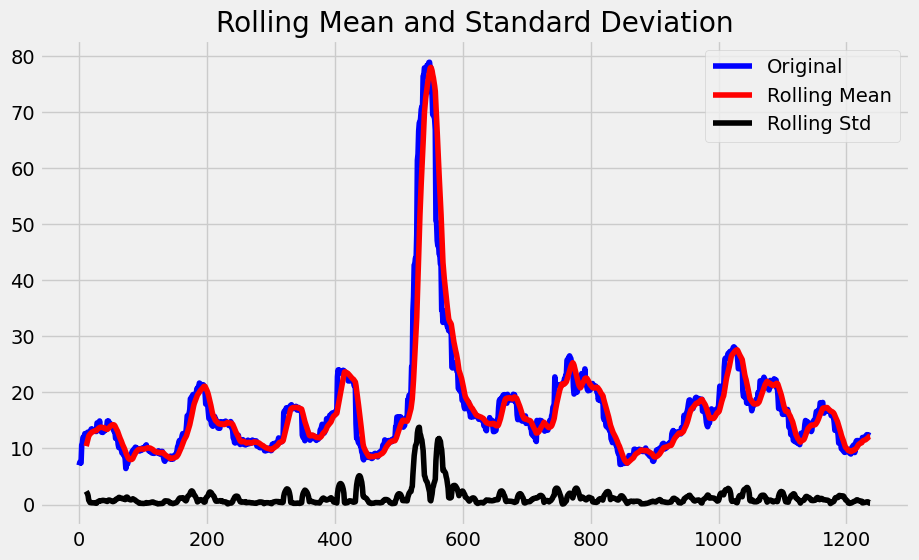

Results of dickey fuller test
Test Statistics                  -4.523848
p-value                           0.000178
No. of lags used                 13.000000
Number of observations used    1224.000000
critical value (1%)              -3.435704
critical value (5%)              -2.863904
critical value (10%)             -2.568029
dtype: float64


In [ ]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df_close)

<Figure size 1000x600 with 0 Axes>

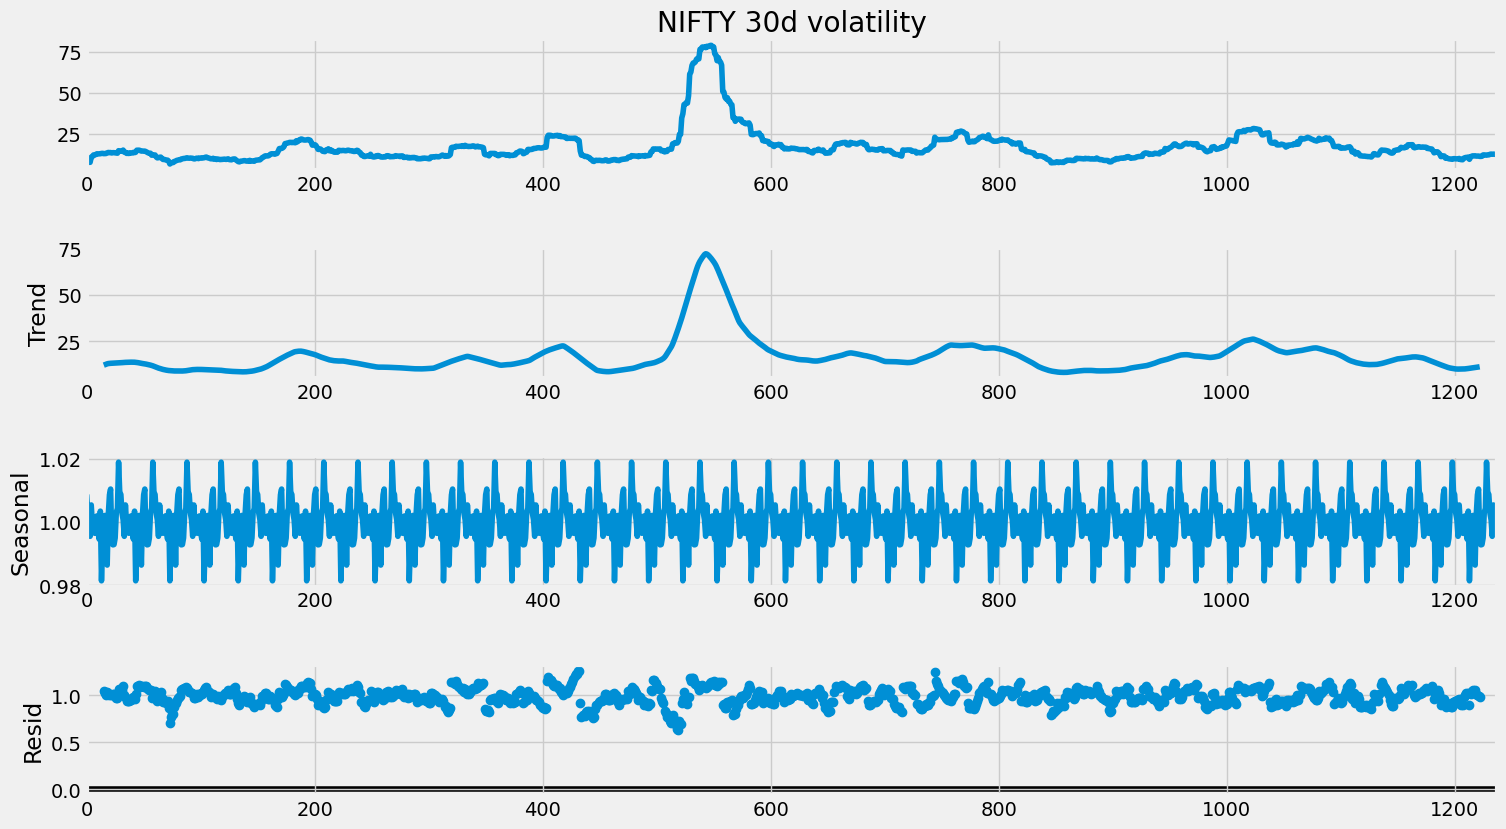

In [ ]:
#To separate the trend and the seasonality from a time series,
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

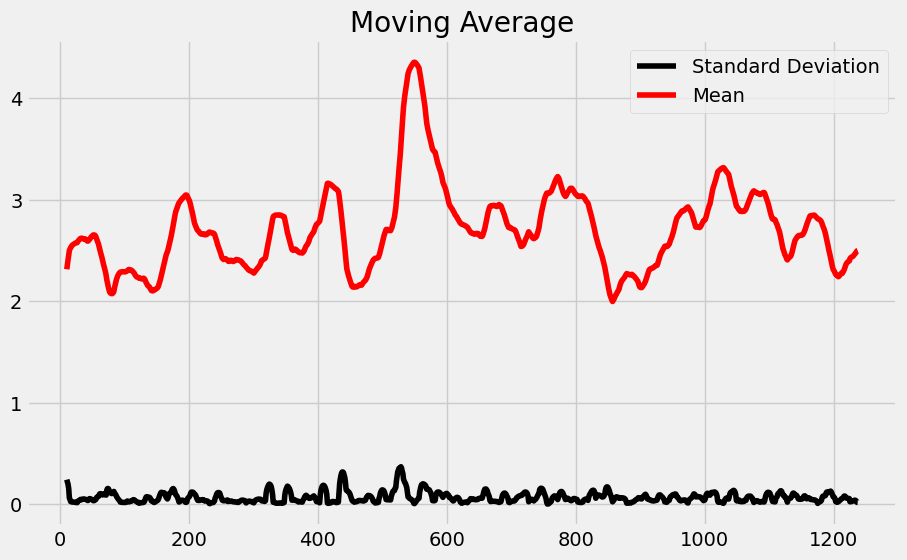

In [ ]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

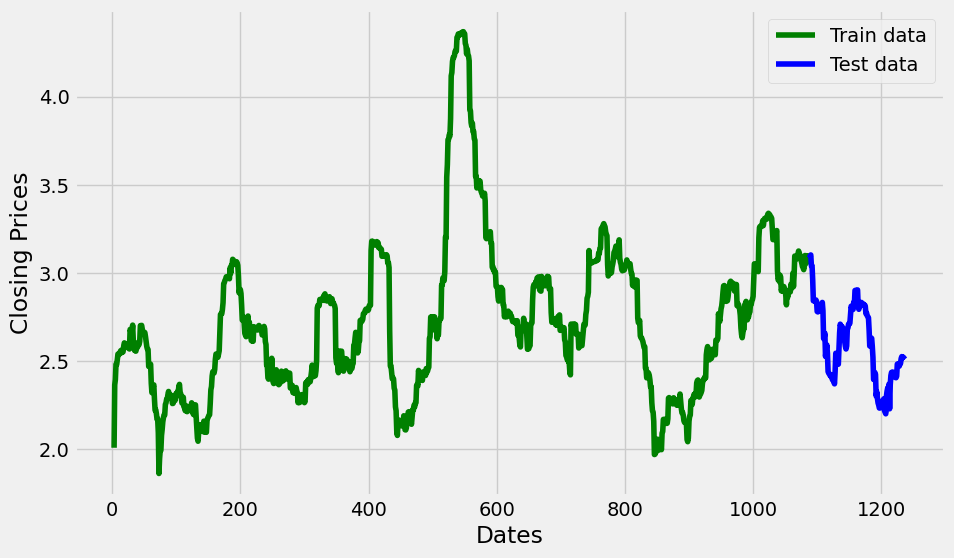

In [ ]:
# # create input-output pairs
# X, Y = LR_create_input_output_pairs(df, 1, 50)
# # split the data into train and test
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)


#split data into train and training set

train_data, test_data = df_log[3:-150], df_log[-150:]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1321.329, Time=0.37 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-9.218, Time=0.70 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5284.108, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-3417.167, Time=1.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-3401.481, Time=4.14 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-3432.089, Time=0.53 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-1000.654, Time=0.87 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-3437.661, Time=2.89 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-3448.614, Time=2.65 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-3437.155, Time=2.01 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-3448.087, Time=2.56 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-3414.801, Time=3.16 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-3428.082, Time=4.36 sec
 ARIMA(4,0,1)(0,0,0)[0] interc

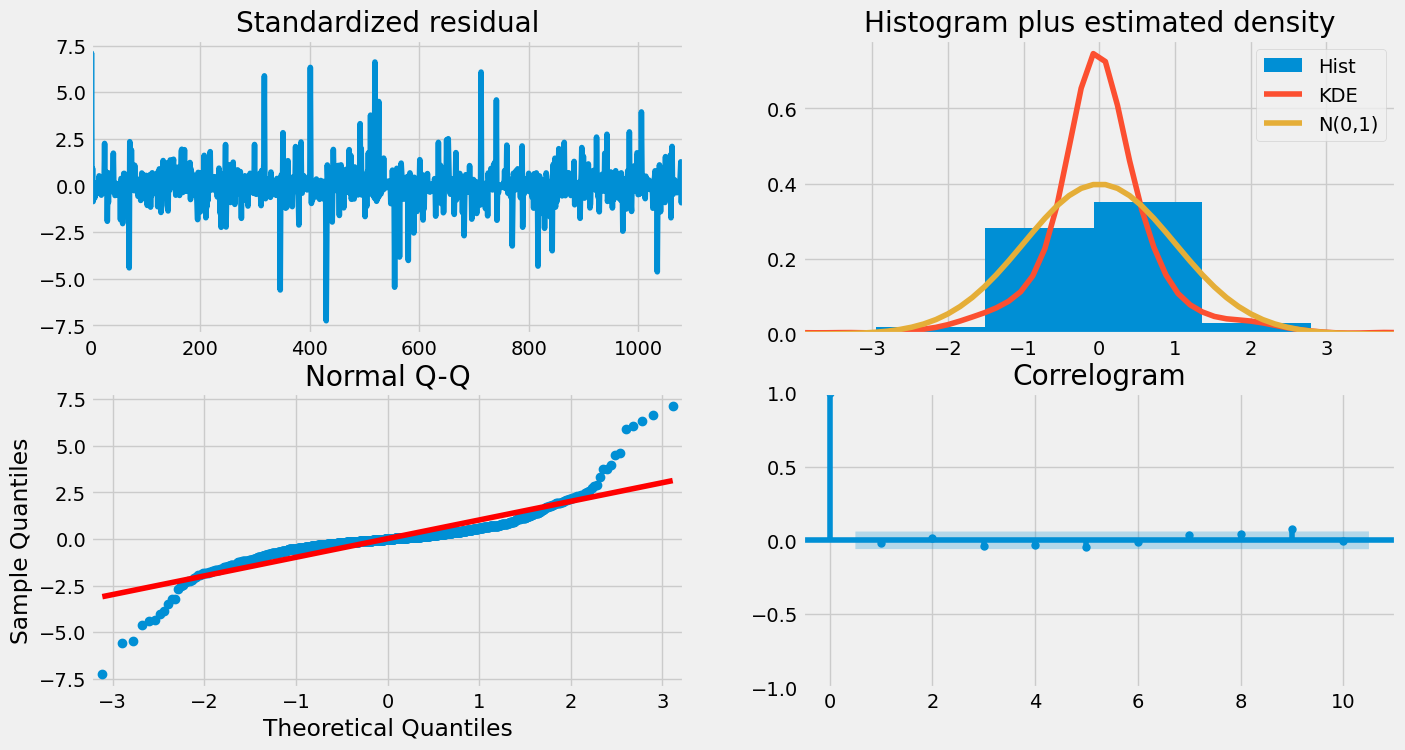

In [ ]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      # max_p=3, max_q=3, # maximum p and q
                      # m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
import statsmodels.api as sm
#Modeling
# Build Model
p = 3
d = 0
q = 2
P = 0
D = 0
Q = 0
S = 0
model = sm.tsa.arima.ARIMA(train_data, order=(p, d, q), trend="t")  # seasonal_order=(P, D, Q, S),
fitted = model.fit()
print(fitted.summary())

                                SARIMAX Results                                 
Dep. Variable:     NIFTY 30d volatility   No. Observations:                 1085
Model:                   ARIMA(3, 0, 2)   Log Likelihood                1727.218
Date:                  Wed, 05 Apr 2023   AIC                          -3440.437
Time:                          17:38:46   BIC                          -3405.512
Sample:                               0   HQIC                         -3427.215
                                 - 1085                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0032      0.002      1.716      0.086      -0.000       0.007
ar.L1          0.8938      0.070     12.696      0.000       0.756       1.032
ar.L2          0.9623      0.069    

In [ ]:
#Forecast

fc = fitted.forecast(len(test_data)) #123?????????????????
# fc_mean = fc.predicted_mean
fc1 = fitted.get_forecast(len(test_data))
conf = fc1.conf_int(alpha=0.05)
print(fc)
print(conf)
print(test_data.index)

1088    3.115005
1089    3.122143
1090    3.126260
1091    3.132865
1092    3.136617
          ...   
1233    3.663460
1234    3.667011
1235    3.670709
1236    3.674263
1237    3.677957
Name: predicted_mean, Length: 150, dtype: float64
      lower NIFTY 30d volatility  upper NIFTY 30d volatility
1088                    3.018550                    3.211460
1089                    2.980695                    3.263591
1090                    2.946443                    3.306076
1091                    2.918777                    3.346953
1092                    2.890165                    3.383069
...                          ...                         ...
1233                    1.935905                    5.391014
1234                    1.934344                    5.399677
1235                    1.932961                    5.408457
1236                    1.931458                    5.417067
1237                    1.930126                    5.425788

[150 rows x 2 columns]
RangeIn

1088    3.115005
1089    3.122143
1090    3.126260
1091    3.132865
1092    3.136617
          ...   
1233    3.663460
1234    3.667011
1235    3.670709
1236    3.674263
1237    3.677957
Name: predicted_mean, Length: 150, dtype: float64


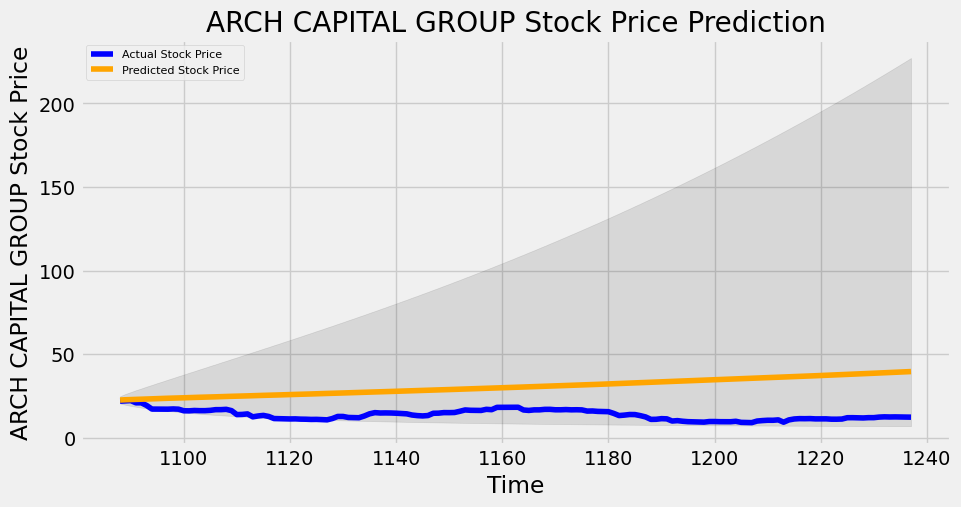

In [ ]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
print(fc)
lower_series = pd.Series(conf['lower NIFTY 30d volatility'], index=test_data.index)
upper_series = pd.Series(conf['upper NIFTY 30d volatility'], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
#plt.plot(np.exp(train_data), label='training data')
plt.plot(np.exp(test_data), color = 'blue', label='Actual Stock Price')
plt.plot(test_data.index, np.exp(fc), color = 'orange',label='Predicted Stock Price')
plt.fill_between(test_data.index, np.exp(lower_series), np.exp(upper_series),
                 color='k', alpha=.10)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))
print('R^2: ' + str(r2_score(np.exp(test_data), np.exp(fc))))

MSE: 0.76816633921608
MAE: 0.8094570118027261
RMSE: 0.8764509907667856
MAPE: 0.3240759101853687
R^2: -35.48819157255565


In [ ]:
df

,Date,NIFTY Index - Volume (L1),(R1) Close,NIFTY 30d volatility,3mo LIBOR,US T-bond 10y yield,CBOE VIX,MSCI EAFE Index,WTI Crude Oil Futures
0,2018-01-29,249220720,11130.40,7.00,1.77225,2.70,13.84,2.70,65.56
1,2018-01-30,234969504,11049.65,7.53,1.77340,2.73,14.79,2.73,64.50
2,2018-01-31,253462576,11027.70,7.46,1.77777,2.72,13.54,2.72,64.73
3,2018-02-01,315743488,11016.90,7.43,1.78698,2.78,13.47,2.78,65.80
4,2018-02-02,291432000,10760.60,10.62,1.78902,2.84,17.31,2.84,65.45
...,...,...,...,...,...,...,...,...,...
1233,2023-01-19,237833984,18107.85,12.39,4.81529,3.39,20.52,3.39,80.33
1234,2023-01-20,237225264,18027.65,12.44,4.81557,3.48,19.85,3.48,81.31
1235,2023-01-23,202460432,18118.55,12.39,4.81771,3.52,19.81,3.52,81.62
1236,2023-01-24,216910304,18118.30,12.34,4.82186,3.46,19.20,3.46,80.13


ARIMA MODEL (try)

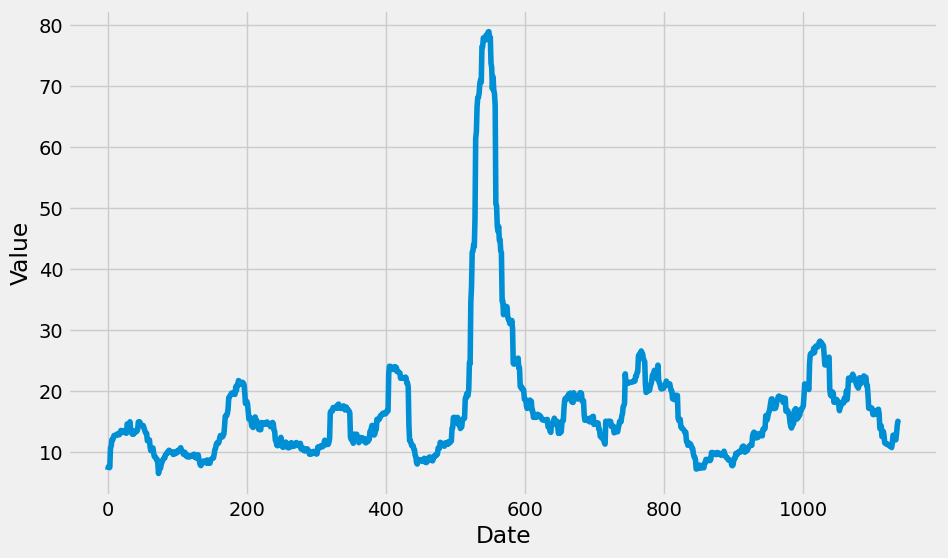

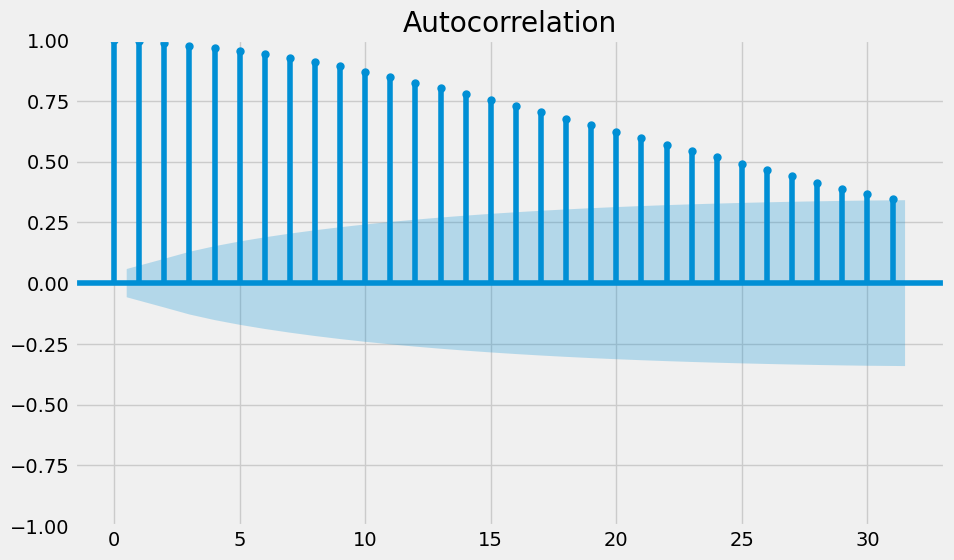

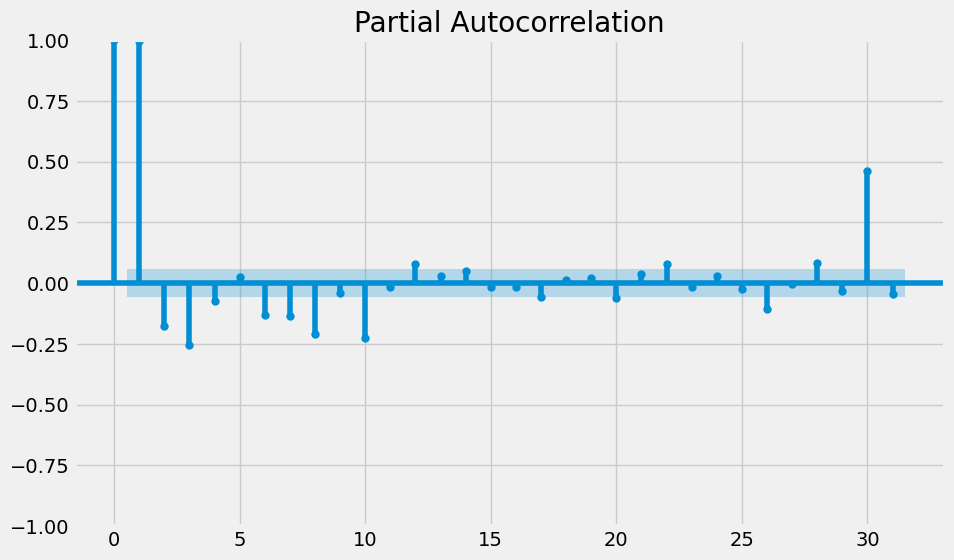

The appropriate order of differencing is 0
The best model according to AIC has order (9.0, 0, 10.0) with AIC value of 3228.420829225252
The best model according to BIC has order (8.0, 0, 7.0) with BIC value of 3317.2019894042755


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Load data
data = df

# Split data into training and testing sets
train = data['NIFTY 30d volatility'].iloc[:-100]
test = data['NIFTY 30d volatility'].loc[-100:]

# Step 1: Stationarity Check
# Plot time series and check for trend, seasonality, and randomness
plt.plot(train)
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# Plot ACF and PACF to identify potential AR and MA terms
plot_acf(train)
plt.show()
plot_pacf(train)
plt.show()

# Step 2: Model Selection
# Identify the appropriate order of differencing, AR, and MA terms using ACF and PACF plots
# For example, if there is a significant autocorrelation at lag 1 in ACF and no significant autocorrelation in PACF, this suggests first-order differencing and an AR(1) model
# The best model is selected based on AIC, BIC, and HQIC values
# For example, a lower AIC value indicates a better fit

# Identify the order of differencing
diff_order = 0
result = adfuller(train)
p_value = result[1]
while p_value > 0.05:
    train = train.diff().dropna()
    diff_order += 1
    result = adfuller(train)
    p_value = result[1]
print(f'The appropriate order of differencing is {diff_order}')

# Identify the order of AR and MA terms
max_lag = 10
aic_list = []
bic_list = []
hqic_list = []
for p in range(max_lag+1):
    for q in range(max_lag+1):
        try:
            model = ARIMA(train, order=(p, diff_order, q))
            fit = model.fit()
            aic_list.append((p, q, fit.aic))
            bic_list.append((p, q, fit.bic))
            hqic_list.append((p, q, fit.hqic))
        except:
            pass

aic_df = pd.DataFrame(aic_list, columns=['AR', 'MA', 'AIC']).sort_values('AIC')
best_aic = aic_df.iloc[0]
bic_df = pd.DataFrame(bic_list, columns=['AR', 'MA', 'BIC']).sort_values('BIC')
best_bic = bic_df.iloc[0]
hqic_df = pd.DataFrame(hqic_list, columns=['AR', 'MA', 'HQIC']).sort_values('HQIC')
best_hqic = hqic_df.iloc[0]

print(f'The best model according to AIC has order ({best_aic["AR"]}, {diff_order}, {best_aic["MA"]}) with AIC value of {best_aic["AIC"]}')
print(f'The best model according to BIC has order ({best_bic["AR"]}, {diff_order}, {best_bic["MA"]}) with BIC value of {best_bic["BIC"]}')
#print(f'The best model according to HQIC has order ({best_hqic["AR"]}, {diff_order}, {best_hqic["MA"]}) with HQIC value of {best_hqic["HQIC"]}')


try 2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

# Load data
data = df

# Define batch sizes for input and output
input_batch_size = 120
output_batch_size = 3

# Loop through data in batches
for i in range(0, len(data), output_batch_size):

    # Split data into training and testing sets
    train_data = data.iloc[i:i+output_batch_size+input_batch_size]
    test_data = data.iloc[i+output_batch_size:i+2*output_batch_size+input_batch_size]

    # Split inputs and output from training data
    train_output = train_data['NIFTY 30d volatility'].iloc[-output_batch_size:]
    train_inputs = train_data.iloc[:-output_batch_size]

    # Split inputs and output from testing data
    test_output = test_data['NIFTY 30d volatility']
    test_inputs = test_data

    # Step 1: Stationarity Check
    # Plot time series and check for trend, seasonality, and randomness
    # plt.plot(train_output)
    # plt.xlabel('Date')
    # plt.ylabel('Value')
    # plt.show()

    # Step 2: Model Selection
    # Use the auto_arima function to automatically select the order of the ARIMA model
    model = auto_arima(train_output, exogenous=train_inputs, start_p=0, start_q=0, max_p=10, max_q=10, d=None, seasonal=True, stepwise=True, trace=True)
    #print(model.summary())

    # Step 3: Model Fitting and Forecasting
    # Fit the ARIMA model with the selected order
    model.fit(train_output, exogenous=train_inputs)

    # Forecast future values
    forecast_output, forecast_stderr = model.predict(n_periods=len(test_data), return_conf_int=True)

    # Step 4: Model Evaluation
    # Compute error metrics
    mse = np.mean((forecast_output - test_output)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(forecast_output - test_output))
    mape = np.mean(np.abs((forecast_output - test_output)/test_output))

    print('MSE:', mse)
    print('RMSE:', rmse)
    print('MAE:', mae)
    print('MAPE:', mape)

    # Plot actual vs forecast values
    # plt.plot(test_output.index, test_output.values, label='Actual')
    # plt.plot(test_output.index, forecast_output, label='Forecast')
    # plt.xlabel('Date')
    # plt.ylabel('Value')
    # plt.legend()
    # plt.show()


Streaming output truncated to the last 5000 lines.

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
MSE: 0.9154777777961929
RMSE: 0.9568060293477424
MAE: 0.9566666666762913
MAPE: 0.06993044858571823
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-12.175, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-11.565, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=26.209, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-7.062, Time=0.27 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.584 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                    3
Model:                        SARIMAX   Log Likelihood                   8.087
Date:                Wed, 05 Apr 2023   AIC                            -12.17

IndexError: ignored

TRY 3

In [ ]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
!pip install pmdarima --quiet
import pmdarima as pm

In [ ]:
# load stock data into pandas DataFrame
df = pd.read_csv('vix_data.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df = df.fillna(method='bfill')
df = df.drop(['(R1) Open', '(R1) High', '(R1) Low'], axis=1)
df = df[::-1]
df.index = df.index[::-1]
df = df[:-1]
df = df.set_index(['Date'])
df.head()

,NIFTY Index - Volume (L1),(R1) Close,NIFTY 30d volatility,3mo LIBOR,US T-bond 10y yield,CBOE VIX,MSCI EAFE Index,WTI Crude Oil Futures
Date,,,,,,,,
2018-01-29,249220720,11130.40,7.00,1.77225,2.70,13.84,2.70,65.56
2018-01-30,234969504,11049.65,7.53,1.77340,2.73,14.79,2.73,64.50
2018-01-31,253462576,11027.70,7.46,1.77777,2.72,13.54,2.72,64.73
2018-02-01,315743488,11016.90,7.43,1.78698,2.78,13.47,2.78,65.80
2018-02-02,291432000,10760.60,10.62,1.78902,2.84,17.31,2.84,65.45


In [ ]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['NIFTY 30d volatility'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   -4.523848
p-value                           0.000178
#Lags Used                       13.000000
Number of Observations Used    1224.000000
Critical Value (1%)              -3.435704
Critical Value (5%)              -2.863904
Critical Value (10%)             -2.568029
dtype: float64


In [ ]:
#Standard ARIMA Model
n = int(len(df)*0.2)
ARIMA_model = pm.auto_arima(df['NIFTY 30d volatility'][:-n],
                      start_p=1,
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)
print(ARIMA_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  991
Model:               SARIMAX(3, 0, 1)   Log Likelihood               -1479.497
Date:                Thu, 06 Apr 2023   AIC                           2970.994
Time:                        11:54:49   BIC                           3000.387
Sample:                             0   HQIC                          2982.170
                                - 991                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0414      0.013      3.256      0.001       0.016       0.066
ar.L1          1.8758      0.029     65.263      0.000       1.820       1.932
ar.L2         -0.8104      0.051    -15.835      0.0

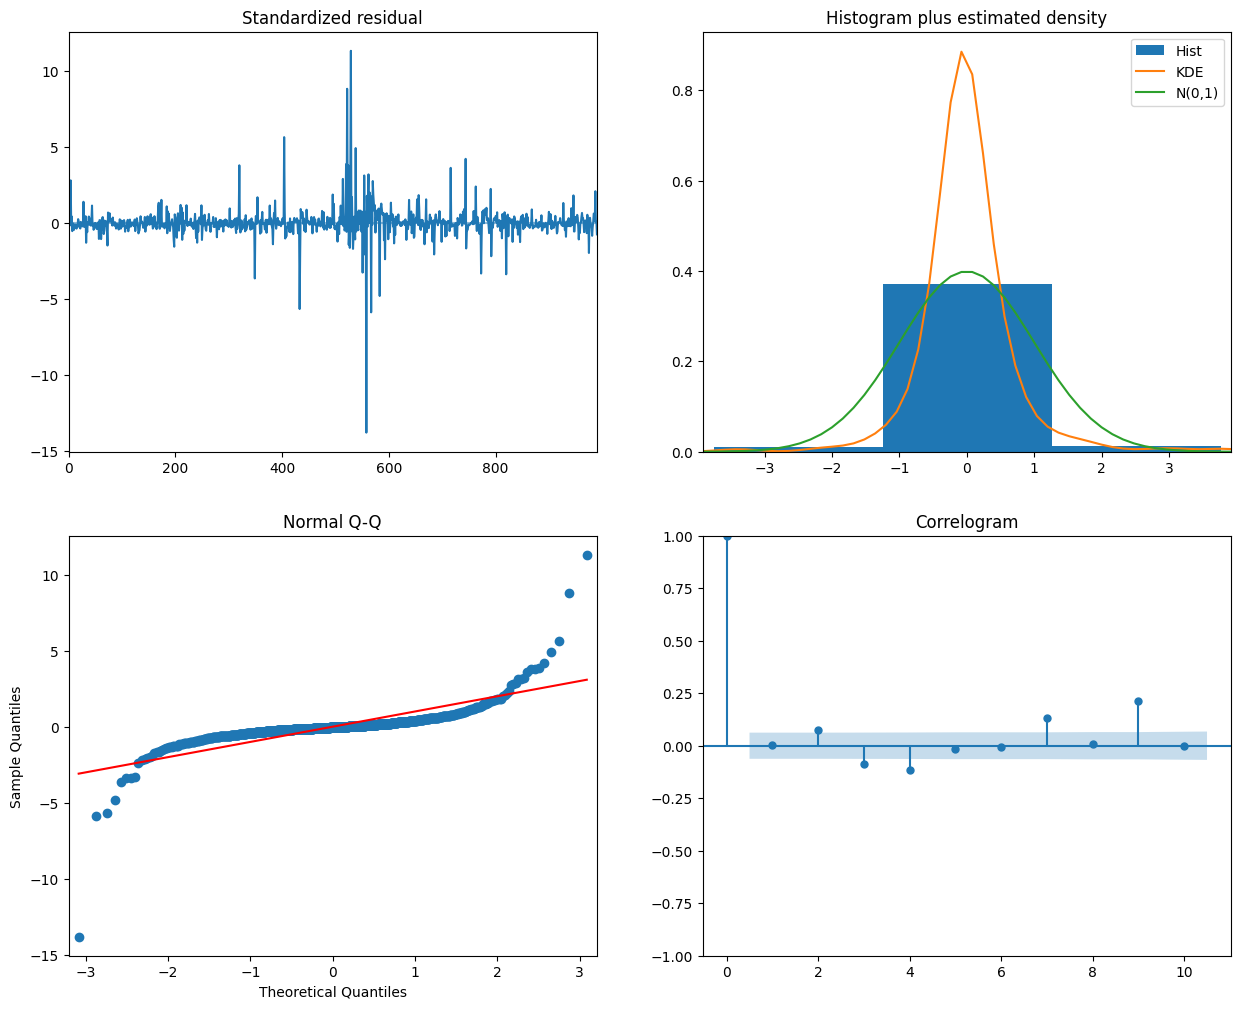

In [ ]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(df['NIFTY 30d volatility'][:-n], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3,
                         m=12, #12 is the frequncy of the cycle
                         start_P=0,
                         seasonal=True, #set to seasonal
                         d=None,
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)
print(ARIMA_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  991
Model:               SARIMAX(3, 0, 1)   Log Likelihood               -1479.497
Date:                Thu, 06 Apr 2023   AIC                           2970.994
Time:                        12:23:12   BIC                           3000.387
Sample:                             0   HQIC                          2982.170
                                - 991                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0414      0.013      3.256      0.001       0.016       0.066
ar.L1          1.8758      0.029     65.263      0.000       1.820       1.932
ar.L2         -0.8104      0.051    -15.835      0.0

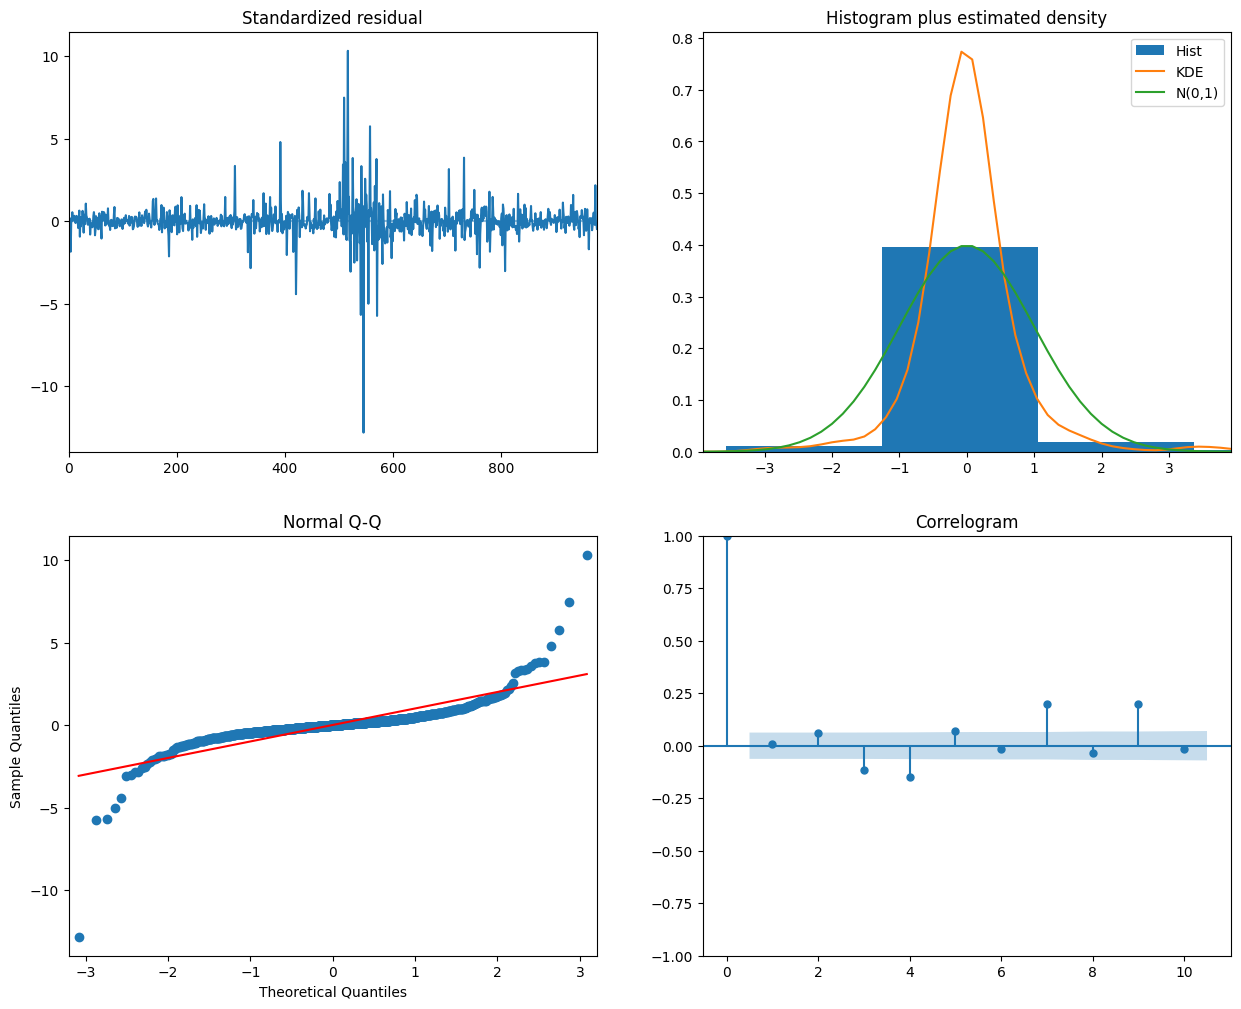

In [ ]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
#adding exogenous variable
dfr = df[['WTI Crude Oil Futures']]
exog = dfr[:450]

# SARIMAX Model
SARIMAX_model = pm.auto_arima(df['NIFTY 30d volatility'][:450], exogenous=exog,
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1,
                           trace=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

SARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  450
Model:             SARIMAX(2, 0, 1)x(2, 1, [], 12)   Log Likelihood                -498.261
Date:                             Thu, 06 Apr 2023   AIC                           1008.522
Time:                                     13:03:14   BIC                           1033.016
Sample:                                          0   HQIC                          1018.187
                                             - 450                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9732      0.016    121.827      0.000       1.941       2.005
ar.L2         -0.9783      0.015    -63.508      0.000      -1.008      -0.948
ma.L1         -0.9346      0.034    -27.584      0.000      -1.001      -0.868
ar.S.L12      -0.7029      0.029    -23.917      0.000      -0.761      -0.645
ar.S.L24      -0.3006      0.033     -9.030      0.000      -0.366      -0.235
sigma2         0.5570      0.013     41.287      0.000       0.531       0.583
===================================================================================
Ljung-Box (L1) (Q):                   1.03   Jarque-Bera (JB):              6684.53
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               4.70   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

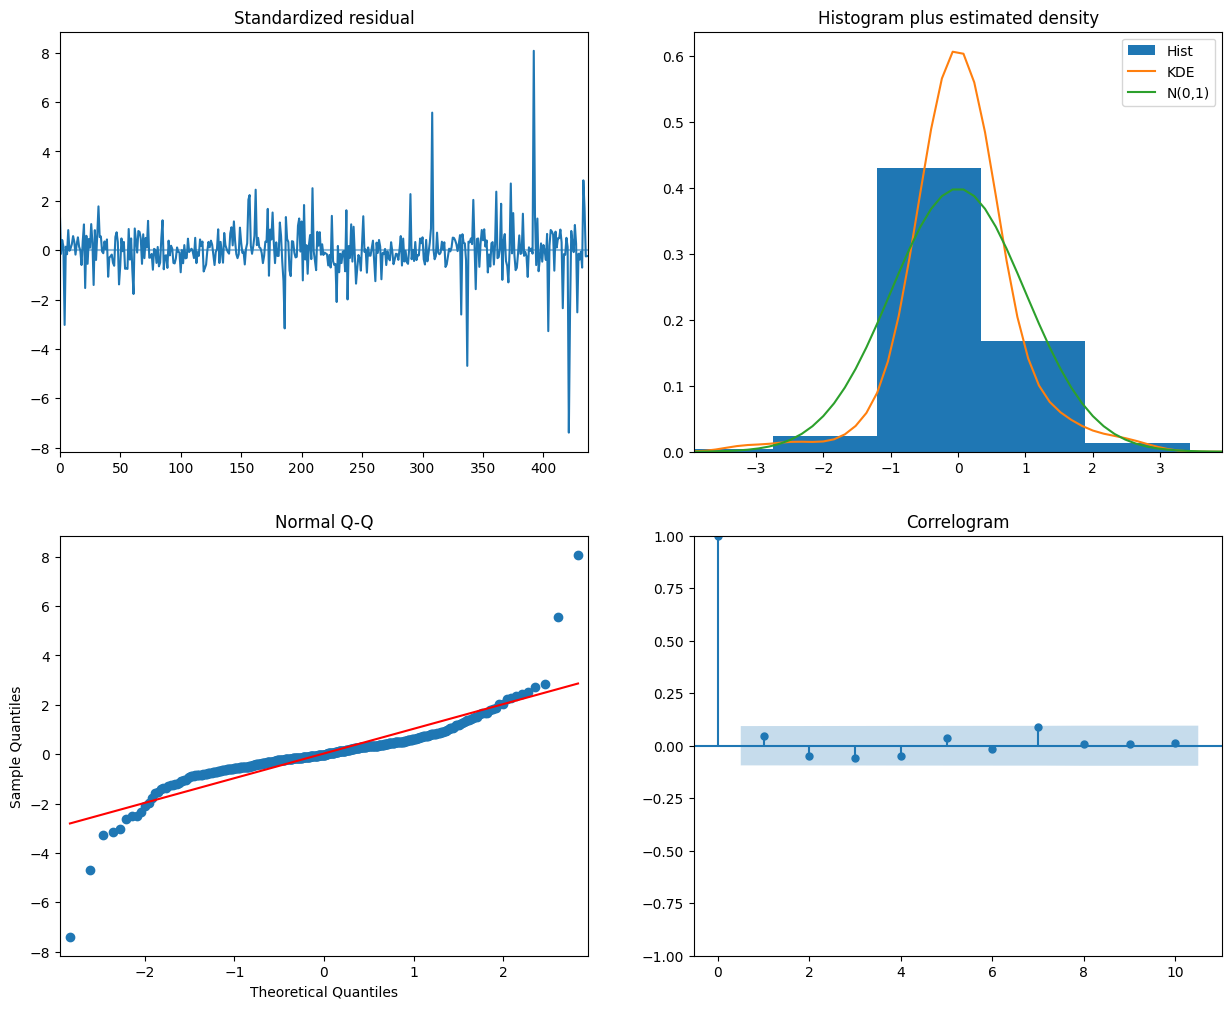

In [ ]:
SARIMAX_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
def sarimax_forecast(SARIMAX_model, df, periods=24):
    # Forecast
    n_periods = periods

    forecast_df = pd.DataFrame(index = df.index[-n:])

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods,
                                            return_conf_int=True,
                                            exogenous=forecast_df[-n:])
    index_of_fc = df.index[-n:]

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(df["NIFTY 30d volatility"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index,
                    lower_series,
                    upper_series,
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Airline Passengers")
    plt.show()

sarimax_forecast(SARIMAX_model, df, periods=n)

In [ ]:
forecast_df = pd.DataFrame(index = df.index[1100:])
a = SARIMAX_model.predict(n_periods=75, return_conf_int=True, exogenous=forecast_df[1100:])

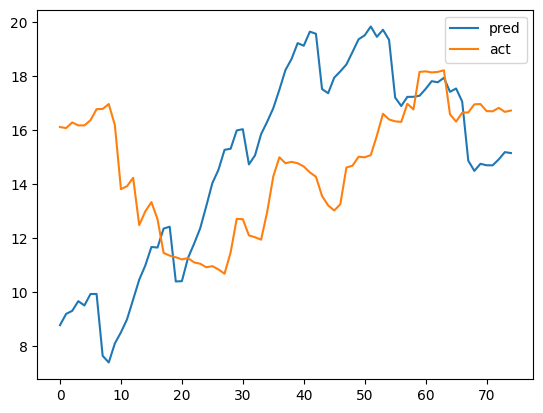

In [ ]:
plt.plot(b.index, b, label ='pred')
c =  df['NIFTY 30d volatility'][1100:1175]
plt.plot(b.index, c, label ='act')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import r2_score
b = a[0][:]
b.index = range(len(a[0]))
np.corrcoef(b, c)

array([[1.        , 0.16800345],
       [0.16800345, 1.        ]])

In [ ]:
def forecast(ARIMA_model, df, test_percentage=0.2):
    # Forecast
    n_periods = int(len(df) * test_percentage)
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(df.index[-int(len(df) * test_percentage)], periods=n_periods, freq='B')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(20,7))
    plt.plot(df["NIFTY 30d volatility"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index,
                    lower_series,
                    upper_series,
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of Daily Volatility")
    plt.show()


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


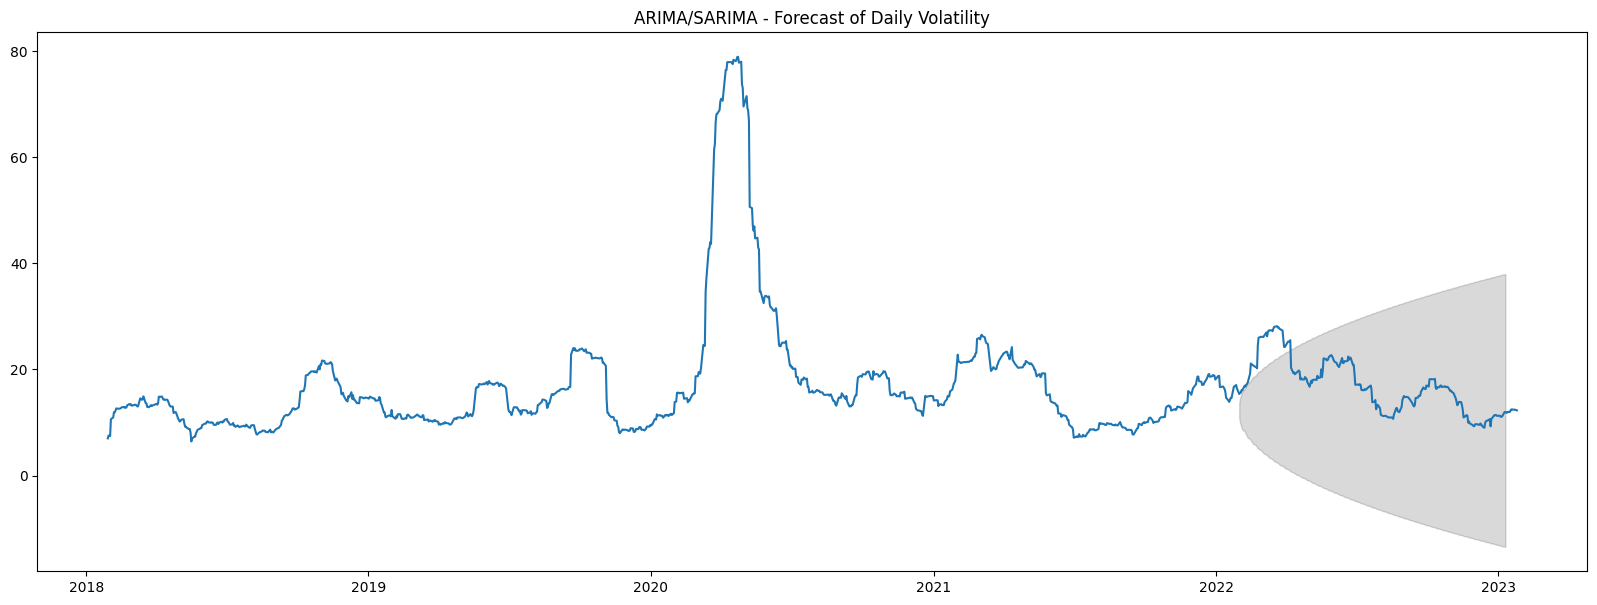

In [ ]:
forecast(ARIMA_model, df)


In [ ]:
def forecast(ARIMA_model, df, last_percentage=0.2):
    # Forecast
    n = int(len(df) * last_percentage)
    train = df[:-n]
    fitted, confint = ARIMA_model.predict(n_periods=n, return_conf_int=True)
    start_date = df.index[-n]
    end_date = df.index[-1]
    index_of_fc = df.index[-n:]
    pd.date_range(start=start_date, end=end_date, periods = n)

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # create DataFrame of actual vs predicted values
    actual = df['NIFTY 30d volatility'][-n:]
    predicted = fitted_series
    print(fitted_series)
    df_forecast = pd.concat([actual, predicted], axis=1)
    df_forecast.columns = ['actual', 'predicted']

    # Plot
    plt.figure(figsize=(20,7))
    plt.plot(df_forecast.index, df_forecast['actual'], color='#1f76b4', label='Actual')
    plt.plot(df_forecast.index, df_forecast['predicted'], color='darkgreen', linestyle='--', label='Predicted')
    plt.fill_between(lower_series.index,
                    lower_series,
                    upper_series,
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of Daily Volatility")
    plt.legend()
    plt.show()

    return fitted_series


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Date
2022-01-31   NaN
2022-02-01   NaN
2022-02-02   NaN
2022-02-03   NaN
2022-02-04   NaN
              ..
2023-01-19   NaN
2023-01-20   NaN
2023-01-23   NaN
2023-01-24   NaN
2023-01-25   NaN
Length: 247, dtype: float64


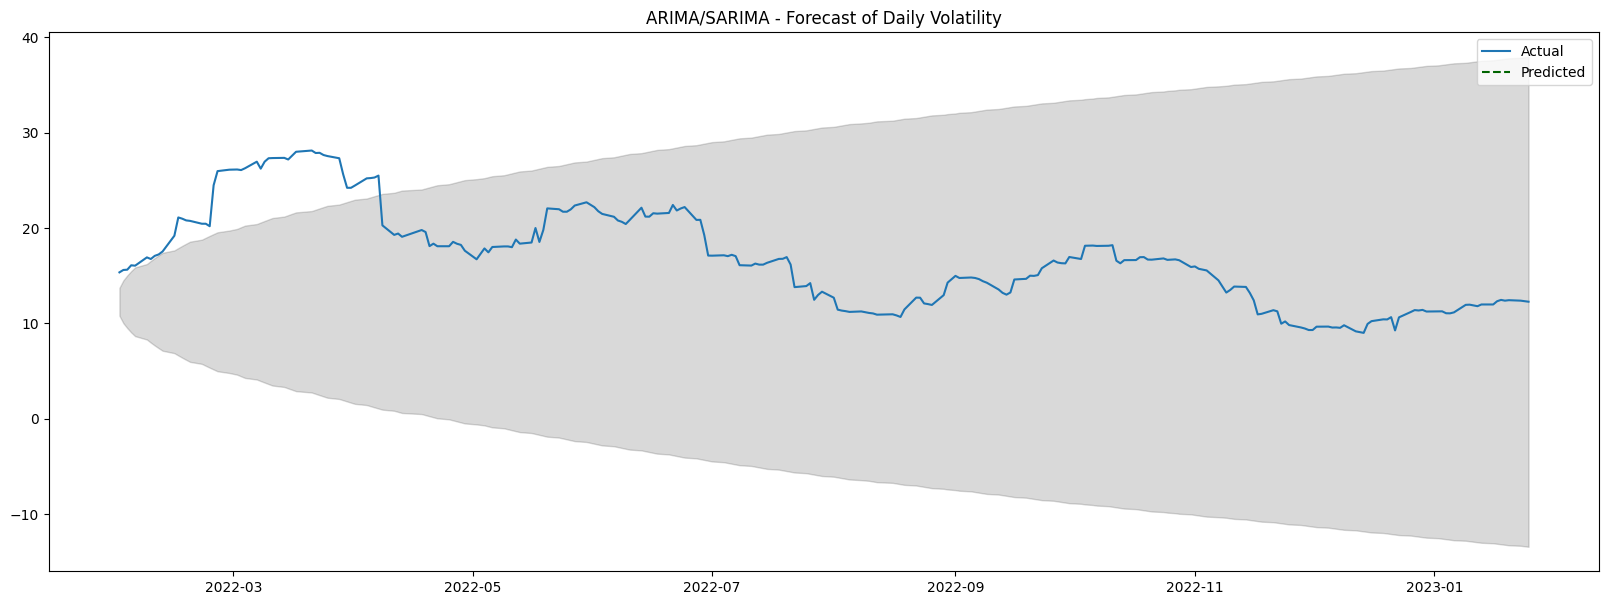

In [ ]:
df_forecast = forecast(ARIMA_model, df)

In [ ]:
df.index.freq

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


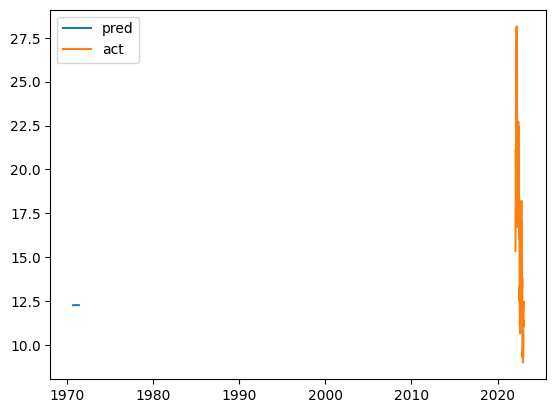

In [ ]:
plt.plot(ARIMA_model.predict(n), label = 'pred')
plt.plot(df['NIFTY 30d volatility'][-n:], label = 'act')
plt.legend(loc='upper left')
plt.show()

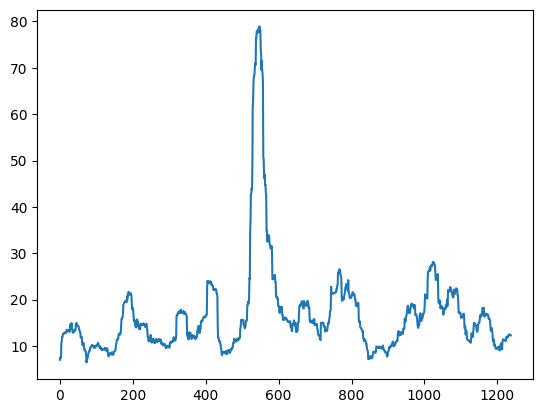

In [ ]:
plt.plot(df['NIFTY 30d volatility'])

In [ ]:
df['NIFTY 30d volatility'][843]

9.16

In [ ]:
450

[97]